# Lanczos 時間序列帶通濾波 (Bandpass Filter)

此程式碼根據 https://github.com/liv0505/Lanczos-Filter 以及NCL的bandpass filter、`filwgts_lanczos`進行修改。

首先建立自訂義函式：

In [1]:
"""
Applying a bandpass filter
(the difference of two lowpass lanczos filters)
to a time-series.

References
----------
    Duchon C. E. (1979) Lanczos Filtering in One and Two Dimensions.
    Journal of Applied Meteorology, Vol 18, pp 1016-1022.
"""

def low_pass_weights(nwts, cutoff):

    import numpy as np

    """Calculate weights for a low pass Lanczos filter.
    Args:
    nwts: int  (Source: NCL)
        A scalar indicating the total number of weights (must be an odd number; nwt >= 3). 
        The more weights, the better the filter, but there is a greater loss of data.
    cutoff: float
        The cutoff frequency in inverse time steps.
    """
    w = np.zeros([nwts])
    n = nwts // 2
    w[n] = 2 * cutoff
    k = np.arange(1., n)
    sigma = np.sin(np.pi * k / n) * n / (np.pi * k)
    firstfactor = np.sin(2. * np.pi * cutoff * k) / (np.pi * k)
    w[n-1:0:-1] = firstfactor * sigma
    w[n+1:-1] = firstfactor * sigma
    return w[1:-1]

def lanczos_bp_filter(data,nwts,fca,fcb,srate): 
    """" 
    Args: 
    nwts: int  (Source: NCL)
        A scalar indicating the total number of weights (must be an odd number; nwt >= 3). 
        The more weights, the better the filter, but there is a greater loss of data.

    fca: float
        A scalar indicating the cut-off frequency of the ideal high or low-pass filter: (0.0 < fca < 0.5).

    fcb: float
        A scalar used only when a band-pass filter is desired. It is the second cut-off frequency (fca < fcb < 0.5).
    """

    import xarray as xr 

    # construct 3 days and 10 days low pass filters
    hfw = low_pass_weights(nwts, fcb*(1/srate))
    lfw = low_pass_weights(nwts, fca*(1/srate))
    weight_high = xr.DataArray(hfw, dims = ['window'])
    weight_low  = xr.DataArray(lfw, dims = ['window'])

    # apply the filters using the rolling method with the weights
    lowpass_hf = data.rolling(time = len(hfw), center = True).construct('window').dot(weight_high)
    lowpass_lf = data.rolling(time = len(lfw), center = True).construct('window').dot(weight_low)

    # the bandpass is the difference of two lowpass filters.
    bandpass = lowpass_hf - lowpass_lf

    return bandpass 

接著我們只需要引用`lanczos_bp_filter`這個函數，就可以計算帶通濾波了。這個函式需要提供幾個引數：
- `data`: 資料的DataArray。
- `nwts`: 帶通濾波的權重 (weights)，必須滿足 `nwts` $\ge $ 3。數值越大時，濾波效果越好，但也會有越多資料損失 (NaN)。一般而言，對於Lanczos的濾波，`nwts=201`。
- `fca`, `fcb`: 帶通濾波的兩個截止頻率，必須滿足 0 < `fca` < `fcb` < 0.5。
- `srate`: 資料的時間解析度，即一天有幾個資料點。

**Example 1:** 計算冬季 (DJF) OLR在10-30天及30-60天的variance佔total variance的比例。

In [2]:
import xarray as xr 
import numpy as np 
import cmaps
import matplotlib as mpl
from matplotlib import pyplot as plt
from cartopy import crs as ccrs   
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
mpl.rcParams['figure.dpi'] = 200

olr = (xr.open_dataset('data/olr.nc')
         .sel(lat=slice(-20,30),lon=slice(40,180)).olr) 

In [3]:
olr_30_60_bp = lanczos_bp_filter(data=olr, nwts=201,fca=(1./60.),fcb=(1./30.),srate=1)
olr_10_30_bp = lanczos_bp_filter(data=olr, nwts=201,fca=(1./20.),fcb=(1./10.),srate=1)

olr_30_60_bp_djf = olr_30_60_bp.sel(time=olr_30_60_bp.time.dt.month.isin([1,2,12]))
olr_djf = olr.sel(time=olr.time.dt.month.isin([1,2,12]))
djf_30_60_var_rt = ( olr_30_60_bp_djf.sel(time=slice('1999-01-01','2020-12-31')).var(axis=0) / 
                              olr_djf.sel(time=slice('1999-01-01','2020-12-31')).var(axis=0)) 

olr_10_30_bp_djf = olr_10_30_bp.sel(time=olr_10_30_bp.time.dt.month.isin([1,2,12]))
djf_10_30_var_rt = ( olr_10_30_bp_djf.sel(time=slice('1999-01-01','2020-12-31')).var(axis=0) / 
                              olr_djf.sel(time=slice('1999-01-01','2020-12-31')).var(axis=0)) 

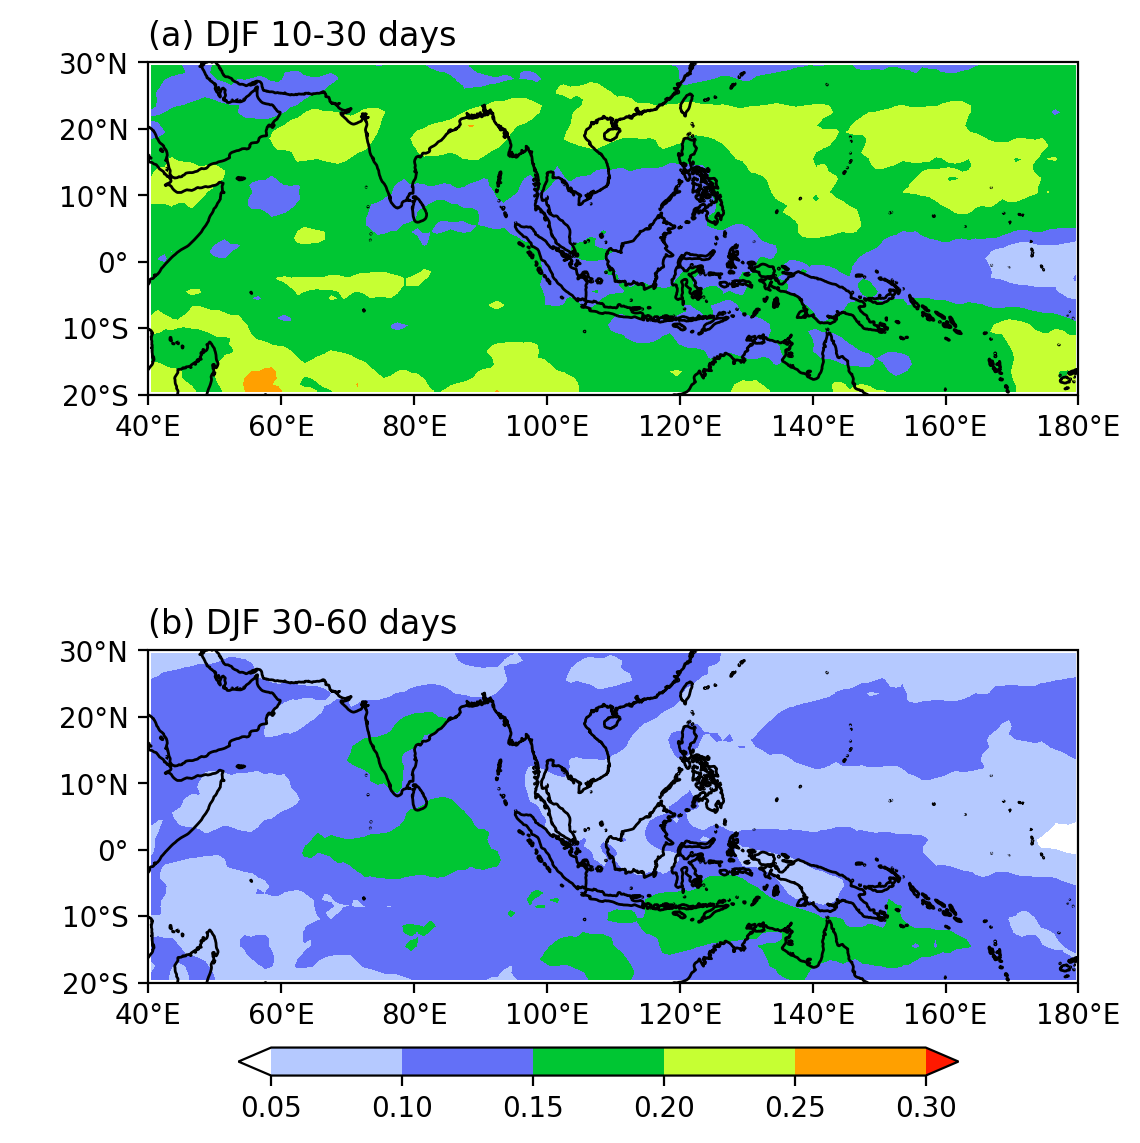

In [4]:
proj = ccrs.PlateCarree()     
fig,axes = plt.subplots(2,1,figsize=(6,7),subplot_kw={'projection':proj})   
ax = axes.flatten()

# 繪圖
clevs = [0.05,0.1,0.15,0.2,0.25,0.3]
cmap = cmaps.precip3_16lev
cf_10_30d = djf_10_30_var_rt.plot.contourf("lon","lat",  
                                            transform=proj,     
                                            ax=ax[0],              
                                            levels=clevs,   
                                            cmap=cmap,   
                                            add_colorbar=False, 
                                            extend='both', 
                                            )
cf_30_60d = djf_30_60_var_rt.plot.contourf("lon","lat",  
                                            transform=proj,   
                                            ax=ax[1],         
                                            levels=clevs,
                                            cmap=cmap,   
                                            add_colorbar=False, 
                                            extend='both',  
                                            )


lon_formatter = LONGITUDE_FORMATTER
lat_formatter = LATITUDE_FORMATTER  
for i in [0,1]:
    ax[i].set_title('')
    ax[i].set_extent([40,180,-20,30],crs=proj)
    ax[i].set_xticks(np.arange(40,200,20), crs=proj)
    ax[i].set_yticks(np.arange(-20,40,10), crs=proj)   
    ax[i].xaxis.set_major_formatter(lon_formatter)
    ax[i].yaxis.set_major_formatter(lat_formatter) 
    ax[i].coastlines()                                    
    ax[i].set_ylabel(' ')   
    ax[i].set_xlabel(' ')

ax[0].set_title('(a) DJF 10-30 days',loc='left')
ax[1].set_title('(b) DJF 30-60 days',loc='left')

# Add a colorbar axis at the bottom of the graph
cbar_ax = fig.add_axes([0.2, 0.1, 0.6, 0.02])
# Draw the colorbar 將colorbar畫在cbar_ax這個軸上。
cbar = fig.colorbar(cf_30_60d, cax=cbar_ax,orientation='horizontal',ticks=clevs)


plt.show()